In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval

# add parent directory to sys path so we could get projects modules
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

In [2]:
# Perfrom Extracting
# and convert column tools from string to list
df = pd.read_csv("../jobs.csv", converters={'tools': literal_eval})
df.head()

,country,date_time,employment_type,num_applications,num_views,tools,year_of_exp
0,"['Ukraine', 'Portugal', 'Spain', 'Argentina', ...",18:30 06.05.2024,['Remote'],10,37,"[Code, Native, IaC, Infrastructure, CD, Cloud]",5
1,['Ukraine'],18:16 06.05.2024,['Remote'],24,67,"[Pika, SQLAlchemy, Celery Beat, AWS, Docker, P...",3
2,"['Ukraine', 'Cyprus']",15:30 06.05.2024,['Remote'],2,19,"[CAPTCHAs, Selenium, Redis, DDD, GCS, SSL, Pyt...",5
3,['Ukraine'],15:08 06.05.2024,"['Office', 'Remote']",25,76,"[CD, Linux, Git, Docker]",3
4,['Israel'],14:10 06.05.2024,['Remote'],22,219,"[Async IO, Great, AWS, GCP, Auto, Azure, Quick...",5


In [3]:
# Perfrom Cleaning, Wrangling

# change year of exp to data type int8
df.loc[:, "year_of_exp"] = df.year_of_exp.astype(np.int8)

# to datetime objects
df.loc[:, "date_time"] = pd.to_datetime(df.date_time, format="%H:%M %d.%m.%Y")

# remove rows where there is no tools
df = df[df.tools.astype(bool)]

In [6]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Concatenate all tools into one Series
all_tools = pd.Series(df['tools'].sum())

# Count the occurrences of each tool
tool_counts = all_tools.value_counts()

# Define a function to remove duplicates and update counts
def removing_duplicates(tool_counts):
    """
    Removing duplicates, exp 'AI', 'AI services' - is same,
    'AI' should stay, and 'AI services' count value should be
    added to 'AI' count
    """
    unq_words = {}
    duplicates = set()

    # Sort tool_counts by length of keys (tool names)
    tool_counts_sorted = tool_counts.sort_index(key=lambda v: v.str.len())

    for tool, count in tool_counts_sorted.items():
        if tool not in duplicates:
            matches = process.extractBests(
                tool, 
                tool_counts_sorted.index, 
                scorer=lambda str1, str2: fuzz.ratio(str1.lower(), str2.lower()),
                score_cutoff=70
            )
            
            # Filter out matches that are similar to the current tool
            filtered_matches = {match for match, score in matches if match != tool and (
                match.lower().startswith(tool.lower()) or score >= 85
            )}
            
            # Add count of similar tools to the current tool
            unq_words[tool] = count + sum(tool_counts[match] for match in filtered_matches)
            duplicates |= filtered_matches

    return unq_words

# Remove duplicates and update counts
tools_dict = removing_duplicates(tool_counts)

# Create DataFrame from dictionary
tools_df = pd.DataFrame({'tools': list(tools_dict.keys()), 'count': list(tools_dict.values())})

# Sort DataFrame by count in descending order
tools_df = tools_df.sort_values(by='count', ascending=False)
tools_df.to_csv("tools.csv", index=False)

tools_df.head()

,tools,count
304,Python,287
372,English,102
68,Sql,93
122,AWS,85
361,Docker,76


In [38]:
tools = pd.read_csv("tools.csv")
tools.tools = tools.tools.replace("CD", "CI/CD")

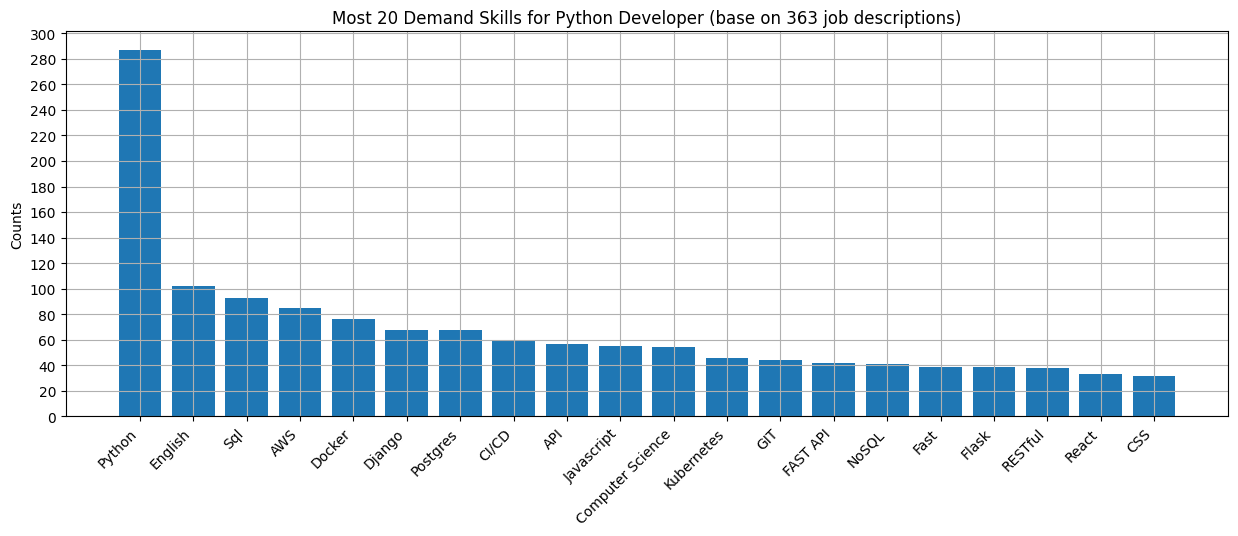

In [49]:
# perform Transforming
import os
import sys

from config import POSITION

# get top 20 demands
top_tools = tools.iloc[:20, :]

plt.figure(figsize=(15, 5))
plt.bar(top_tools.tools, top_tools["count"])

plt.title(f"Most 20 Demand Skills for {POSITION} Developer (base on {df.shape[0]} job descriptions)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Counts")
plt.yticks(range(0, tools["count"].max() + 20, 20))
plt.grid(True)
plt.show()